In [1]:
import contracts
contracts.disable_all()

In [2]:
import duckietown_uplan as uplan

INFO:dt-uplan:duckietown_uplan 1.0.0
INFO:dt-world:duckietown-world 1.0.19
DEBUG:dt-serialization:Registering class Serializable
DEBUG:dt-serialization:Registering class GenericData
DEBUG:dt-serialization:Registering class Sequence
DEBUG:dt-serialization:Registering class SampledSequence
DEBUG:dt-serialization:Registering class Constant
DEBUG:dt-serialization:Registering class RectangularArea
DEBUG:dt-serialization:Registering class TransformSequence
DEBUG:dt-serialization:Registering class VariableTransformSequence
DEBUG:dt-serialization:Registering class SE2Transform
DEBUG:dt-serialization:Registering class Scale2D
DEBUG:dt-serialization:Registering class Matrix2D
DEBUG:dt-serialization:Registering class SpatialRelation
DEBUG:dt-serialization:Registering class GroundTruth
DEBUG:dt-serialization:Registering class PlacedObject
DEBUG:dt-serialization:Registering class EvaluatedMetric
DEBUG:dt-serialization:Registering class GenericObject
DEBUG:dt-serialization:Registering class Duckie
D

In [3]:
import duckietown_world as dw
import numpy as np
from duckietown_uplan.algo.velocity_profiler import VelocityProfiler
np.random.seed(3)
current_map = dw.load_map('4way')
simulation_exp = uplan.ConstantProbabiltiySim(current_map, 1)
simulation_exp.execute_simulation(1)
path = simulation_exp.duckie_town.duckie_citizens[0].get_path()

INFO:dt-world:loading map 4way


Started move function
distance to travel:  0.25
distance to next control point is :  0.0
reached a control point here
reached a control point here


In [9]:
def cost_function(delta_v_norm=0, delta_unc=0, unc=0, next_vel_norm=0, error_norm=0):
    a1 = 3
    a2 = 0
    a3 = 4
    a4 = 0
    a5 = 0.1
    
    sum_of_terms = a1*delta_v_norm**2 + a2*delta_unc + a3*unc**2 + \
        a4*next_vel_norm**2 + a5*error_norm**2
    return sum_of_terms

def gen_uncertainties(num):
    f = lambda x: 1/2 - 1/2*np.cos(x)
    t = np.linspace(0, 4*np.pi, num)
    uncertainties = [f(x) for x in t]
    return uncertainties

vel_prof = VelocityProfiler(10, 100, 10)
uncertainties = gen_uncertainties(len(path))
traj = vel_prof.get_velocity_profile(50, path, uncertainties, cost_function)

Text(0, 0.5, 'Probability')

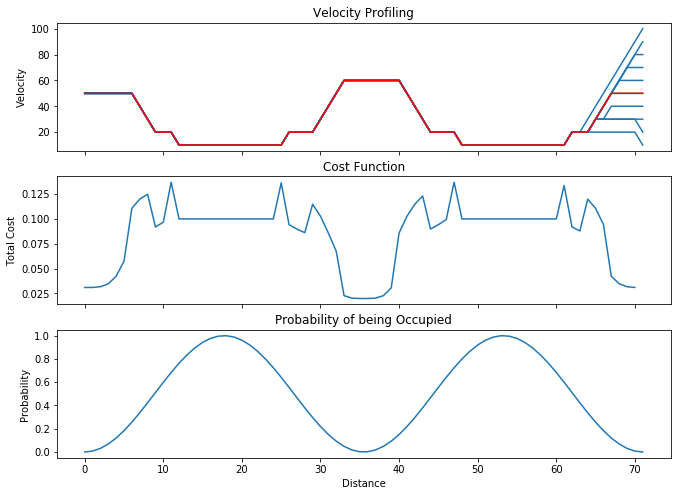

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

f, axarr = plt.subplots(3, sharex=True, figsize=(11, 8))
for cost, vels in vel_prof.trajectory_history:
    axarr[0].plot(vels, c='C0')
axarr[0].plot(traj, c='r')
axarr[0].set_title('Velocity Profiling')
axarr[0].set_ylabel("Velocity")
axarr[1].plot(vel_prof.cost_array, c="C0")
axarr[1].set_title('Cost Function')
axarr[1].set_ylabel("Total Cost")
axarr[2].plot(uncertainties, c="C0")
axarr[2].set_title('Probability of being Occupied')
axarr[2].set_xlabel("Distance")
axarr[2].set_ylabel("Probability")


for i, j in vel_prof.vel_graph.edges():
    if i[0] == 0 and j[0] == 1:
        print(str(i)+str(j) +"_"+ str(vel_prof.vel_graph[i][j]))

In [6]:
def draw_graph(G0, pos=None):
    import networkx as nx
    from matplotlib import pyplot as plt
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))    
    nx.draw(G0,pos,labels={node:node for node in G0.nodes()})
    def edge_label(a, b):
        datas = G0.get_edge_data(a, b)
        s = '%d edge%s' % (len(datas), 's' if len(datas)>=2 else '')
        for k, v in datas.items():
            if v:
                if 'label' in v:
                    s += '\n %s' % v['label']
                else:
                    s += '\n %s' %v
        return s
    #edge_labels = dict([ ((a,b), edge_label(a,b)) for a,b in G0.edges()])
    nx.draw_networkx_edge_labels(G0,pos,edge_labels=None,font_color='red')
    plt.axis('off')
    plt.show()

%matplotlib inline
import geometry as geo
pos = {}
for n in vel_prof.vel_graph:
    pos[n] = (n[0], n[1])
draw_graph(vel_prof.vel_graph, pos=pos)